# Final Exam AML


## 1. Classification Project




In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aseemdandgaval/23-pet-breeds-image-classification")

print("Path to dataset files:", path)

100%|██████████| 794M/794M [00:37<00:00, 22.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/aseemdandgaval/23-pet-breeds-image-classification/versions/2


In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import torch.nn as nn
from torchvision import models
import torch.optim as optim

In [ ]:
data_dir = '/root/.cache/kagglehub/datasets/aseemdandgaval/23-pet-breeds-image-classification/versions/2/Pet_Breeds'  # Укажите путь к папке с 23 подкатегориями

# Аугментация для тренировочного набора данных
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),       # Случайное горизонтальное отражение
    transforms.RandomRotation(degrees=30),        # Случайное вращение на ±30 градусов
    transforms.ColorJitter(brightness=0.2,        # Изменение яркости
                           contrast=0.2,
                           saturation=0.2,
                           hue=0.1),
    transforms.RandomGrayscale(p=0.1),            # Преобразование в черно-белое с вероятностью 10%
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],   # Нормализация для моделей ImageNet
                         [0.229, 0.224, 0.225])
])

# Преобразования для валидационного и тестового набора данных (без аугментации)
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Загрузка датасета
full_dataset = datasets.ImageFolder(data_dir, transform=val_test_transform)  # Используем базовые преобразования для деления

# Отображение всех классов в датасете
classes = full_dataset.classes
print(f"Классы в датасете: {classes}")

# Разделение на тренировочный, валидационный и тестовый наборы
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Применение аугментации к тренировочному набору
train_dataset.dataset.transform = train_transform  # Изменяем трансформацию только для тренировочного набора

# Создание DataLoader для каждого набора данных
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f"Размеры наборов данных: train={len(train_dataset)}, val={len(val_dataset)}, test={len(test_dataset)}")

Классы в датасете: ['abyssinian', 'american shorthair', 'beagle', 'boxer', 'bulldog', 'chihuahua', 'corgi', 'dachshund', 'german shepherd', 'golden retriever', 'husky', 'labrador', 'maine coon', 'mumbai cat', 'persian cat', 'pomeranian', 'pug', 'ragdoll cat', 'rottwiler', 'shiba inu', 'siamese cat', 'sphynx', 'yorkshire terrier']
Размеры наборов данных: train=2716, val=582, test=583


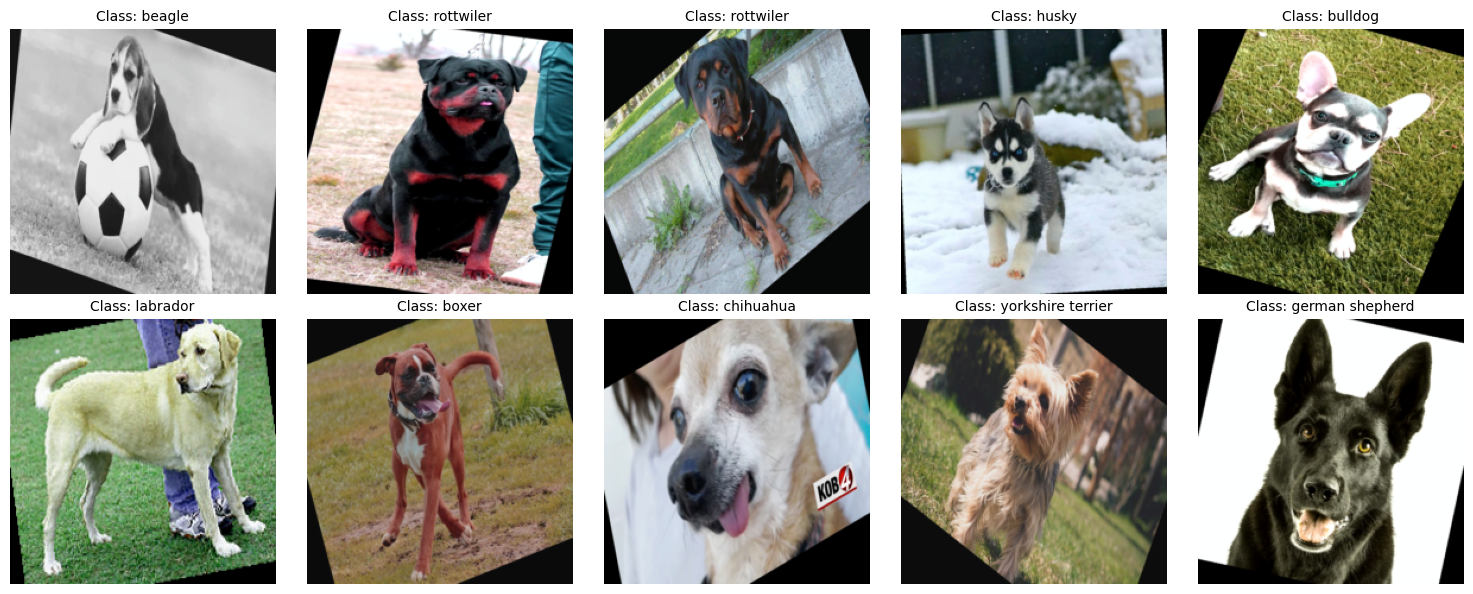

In [ ]:
# Отображение 10 изображений с соответствующими классами
def display_images_with_labels(inputs, labels, classes, num_images=10, nrow=5):
    # Создаем фигуру для отображения
    fig, axes = plt.subplots(nrows=(num_images // nrow), ncols=nrow, figsize=(15, 6))
    axes = axes.flatten()

    for i in range(num_images):
        image = inputs[i].numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean  # Денормализация
        image = np.clip(image, 0, 1)

        axes[i].imshow(image)
        axes[i].set_title(f"Class: {classes[labels[i]]}", fontsize=10)
        axes[i].axis("off")

    # Убираем лишние пустые оси (если есть)
    for ax in axes[num_images:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


# Пример использования функции
inputs, labels = next(iter(train_loader))
display_images_with_labels(inputs[:10], labels[:10], classes, num_images=10, nrow=5)


In [ ]:
base_model = models.resnet18(pretrained=True)

# Изменение последнего слоя
num_features = base_model.fc.in_features
base_model.fc = nn.Linear(num_features, len(full_dataset.classes))  # Количество классов

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 158MB/s]


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

train_losses = []
val_accuracies = []
val_f1_scores = []
val_precisions = []
val_recalls = []

def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):

    for epoch in range(num_epochs):
        start_time = time.time()
        print(f"Epoch {epoch + 1} of {num_epochs}")

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            all_preds = []  # Для сохранения предсказаний (только для 'val')
            all_labels = []  # Для сохранения истинных меток (только для 'val')

            for inputs, labels in dataloaders[phase]:
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Сохраняем предсказания и истинные метки для метрик (только для 'val')
                if phase == 'val':
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            if phase == 'train':
                train_losses.append(epoch_loss)
                print(f"  Training Loss: \t{epoch_loss:.6f}")
            else:
                # Сохраняем точность для сравнения
                val_accuracies.append(epoch_acc)

                # Вычисляем метрики
                f1 = f1_score(all_labels, all_preds, average='weighted')
                precision = precision_score(all_labels, all_preds, average='weighted')
                recall = recall_score(all_labels, all_preds, average='weighted')

                # Сохраняем метрики
                val_f1_scores.append(f1)
                val_precisions.append(precision)
                val_recalls.append(recall)

                print(f"  Validation Accuracy: \t{epoch_acc:.2%}")
                print(f"  F1 Score: \t\t\t{f1:.4f}")
                print(f"  Precision: \t\t\t{precision:.4f}")
                print(f"  Recall: \t\t\t{recall:.4f}")

        end_time = time.time()
        print(f"Epoch {epoch + 1} took {end_time - start_time:.3f}s\n")

    return model


In [8]:
# Подготовка компонентов
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(base_model.parameters(), lr=0.001, momentum=0.9)

# Создание словаря с DataLoader
dataloaders = {'train': train_loader, 'val': val_loader}

# Обучение базовой модели
base_model = train_model(base_model, dataloaders, criterion, optimizer, num_epochs=10)


Epoch 1 of 10
  Training Loss: 	3.162506


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Validation Accuracy: 	26.29%
  F1 Score: 			0.2383
  Precision: 			0.2745
  Recall: 			0.2629
Epoch 1 took 1530.571s

Epoch 2 of 10
  Training Loss: 	2.410132
  Validation Accuracy: 	55.50%
  F1 Score: 			0.5331
  Precision: 			0.5686
  Recall: 			0.5550
Epoch 2 took 1522.829s

Epoch 3 of 10
  Training Loss: 	1.771205
  Validation Accuracy: 	69.93%
  F1 Score: 			0.6878
  Precision: 			0.7087
  Recall: 			0.6993
Epoch 3 took 1523.889s

Epoch 4 of 10
  Training Loss: 	1.358959
  Validation Accuracy: 	77.32%
  F1 Score: 			0.7689
  Precision: 			0.7814
  Recall: 			0.7732
Epoch 4 took 1506.530s

Epoch 5 of 10
  Training Loss: 	1.079341
  Validation Accuracy: 	81.27%
  F1 Score: 			0.8107
  Precision: 			0.8223
  Recall: 			0.8127
Epoch 5 took 1509.664s

Epoch 6 of 10
  Training Loss: 	0.905201
  Validation Accuracy: 	81.62%
  F1 Score: 			0.8132
  Precision: 			0.8261
  Recall: 			0.8162
Epoch 6 took 1506.201s

Epoch 7 of 10
  Training Loss: 	0.795113
  Validation Accuracy: 	83.68%
  F

In [9]:
# После завершения обучения
avg_train_loss = np.mean(train_losses)
avg_val_accuracy = np.mean(val_accuracies)
avg_val_f1 = np.mean(val_f1_scores)
avg_val_precision = np.mean(val_precisions)
avg_val_recall = np.mean(val_recalls)

print(f"\nAverage Training Loss: {avg_train_loss:.6f}")
print(f"Average Validation Accuracy: {avg_val_accuracy:.2%}")
print(f"Average Validation F1 Score: {avg_val_f1:.4f}")
print(f"Average Validation Precision: {avg_val_precision:.4f}")
print(f"Average Validation Recall: {avg_val_recall:.4f}")


Average Training Loss: 1.342650
Average Validation Accuracy: 72.54%
Average Validation F1 Score: 0.7181
Average Validation Precision: 0.7349
Average Validation Recall: 0.7254


In [10]:
def visualize_predictions(model, dataloader, classes, num_images=8):
    model.eval()
    inputs, labels = next(iter(dataloader))
    outputs = model(inputs)
    probs = torch.nn.functional.softmax(outputs, dim=1)  # Вычисление вероятностей
    _, preds = torch.max(outputs, 1)

    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 6))
    axes = axes.flatten()

    for i in range(num_images):
        image = inputs[i].numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

        axes[i].imshow(image)

        # Добавление вероятности в заголовок
        prob = probs[i][preds[i]].item()  # Получение вероятности для предсказанного класса
        title = f"Pred: {classes[preds[i]]} ({prob:.2f}), True: {classes[labels[i]]}"
        axes[i].set_title(title, fontsize=10)

        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

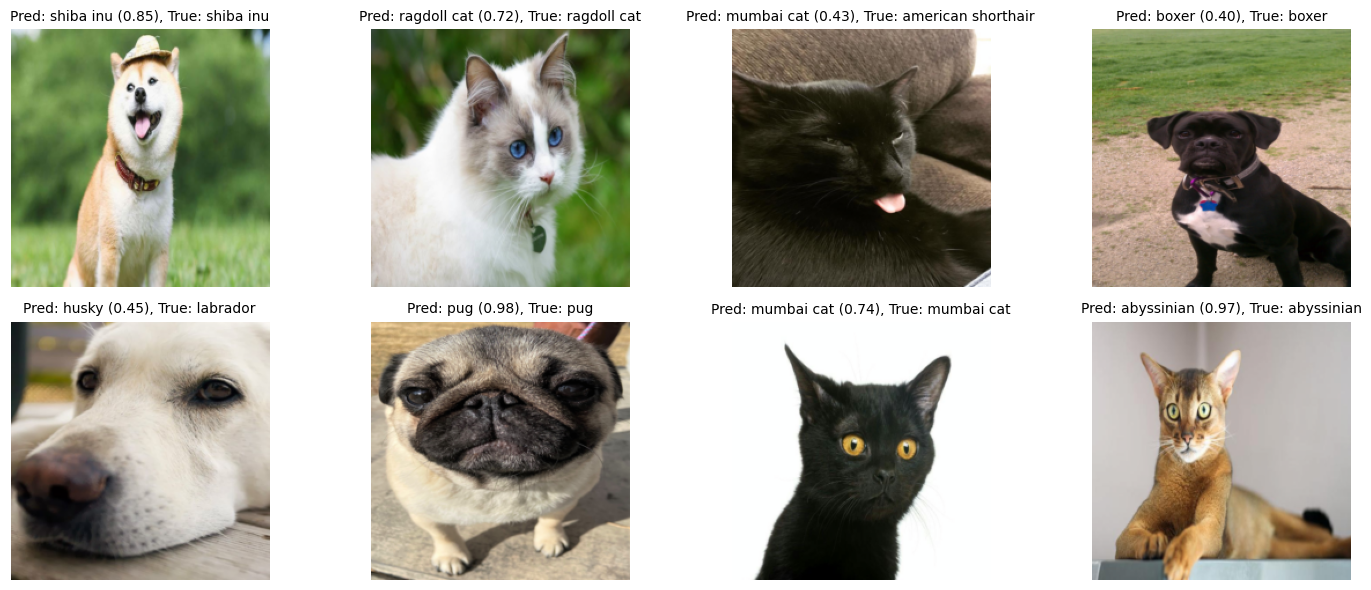

In [ ]:
visualize_predictions(base_model, val_loader, full_dataset.classes, num_images=8)  # num_images=8 для 8 фото

In [11]:
# Предположим, что model — это экземпляр вашей модели
torch.save(base_model.state_dict(), 'base_model_state.pth')
torch.save(base_model, 'base_model_full.pth')

In [12]:
class ImprovedModel(nn.Module):
    def __init__(self, base_model, num_classes):
        super(ImprovedModel, self).__init__()
        self.features = nn.Sequential(*list(base_model.children())[:-1])  # Все кроме последнего слоя
        self.classifier = nn.Sequential(
            nn.Linear(base_model.fc.in_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

improved_model = ImprovedModel(base_model, len(full_dataset.classes))

# Обучение улучшенной модели
optimizer = optim.SGD(improved_model.parameters(), lr=0.001, momentum=0.9)

improved_model = train_model(improved_model, dataloaders, criterion, optimizer, num_epochs=10)


Epoch 1 of 10
  Training Loss: 	2.613350
  Validation Accuracy: 	72.34%
  F1 Score: 			0.7169
  Precision: 			0.7536
  Recall: 			0.7234
Epoch 1 took 1513.976s

Epoch 2 of 10
  Training Loss: 	1.130995
  Validation Accuracy: 	84.02%
  F1 Score: 			0.8384
  Precision: 			0.8498
  Recall: 			0.8402
Epoch 2 took 1518.236s

Epoch 3 of 10
  Training Loss: 	0.757892
  Validation Accuracy: 	84.36%
  F1 Score: 			0.8414
  Precision: 			0.8465
  Recall: 			0.8436
Epoch 3 took 1525.607s

Epoch 4 of 10
  Training Loss: 	0.613939
  Validation Accuracy: 	85.05%
  F1 Score: 			0.8498
  Precision: 			0.8566
  Recall: 			0.8505
Epoch 4 took 1515.369s

Epoch 5 of 10
  Training Loss: 	0.551065
  Validation Accuracy: 	85.57%
  F1 Score: 			0.8544
  Precision: 			0.8638
  Recall: 			0.8557
Epoch 5 took 1552.791s

Epoch 6 of 10
  Training Loss: 	0.492041
  Validation Accuracy: 	85.40%
  F1 Score: 			0.8536
  Precision: 			0.8613
  Recall: 			0.8540
Epoch 6 took 1514.116s

Epoch 7 of 10
  Training Loss: 	0.

In [13]:
# После завершения обучения
avg_train_loss = np.mean(train_losses)
avg_val_accuracy = np.mean(val_accuracies)
avg_val_f1 = np.mean(val_f1_scores)
avg_val_precision = np.mean(val_precisions)
avg_val_recall = np.mean(val_recalls)

print(f"\nAverage Training Loss: {avg_train_loss:.6f}")
print(f"Average Validation Accuracy: {avg_val_accuracy:.2%}")
print(f"Average Validation F1 Score: {avg_val_f1:.4f}")
print(f"Average Validation Precision: {avg_val_precision:.4f}")
print(f"Average Validation Recall: {avg_val_recall:.4f}")


Average Training Loss: 1.059965
Average Validation Accuracy: 78.24%
Average Validation F1 Score: 0.7778
Average Validation Precision: 0.7916
Average Validation Recall: 0.7824


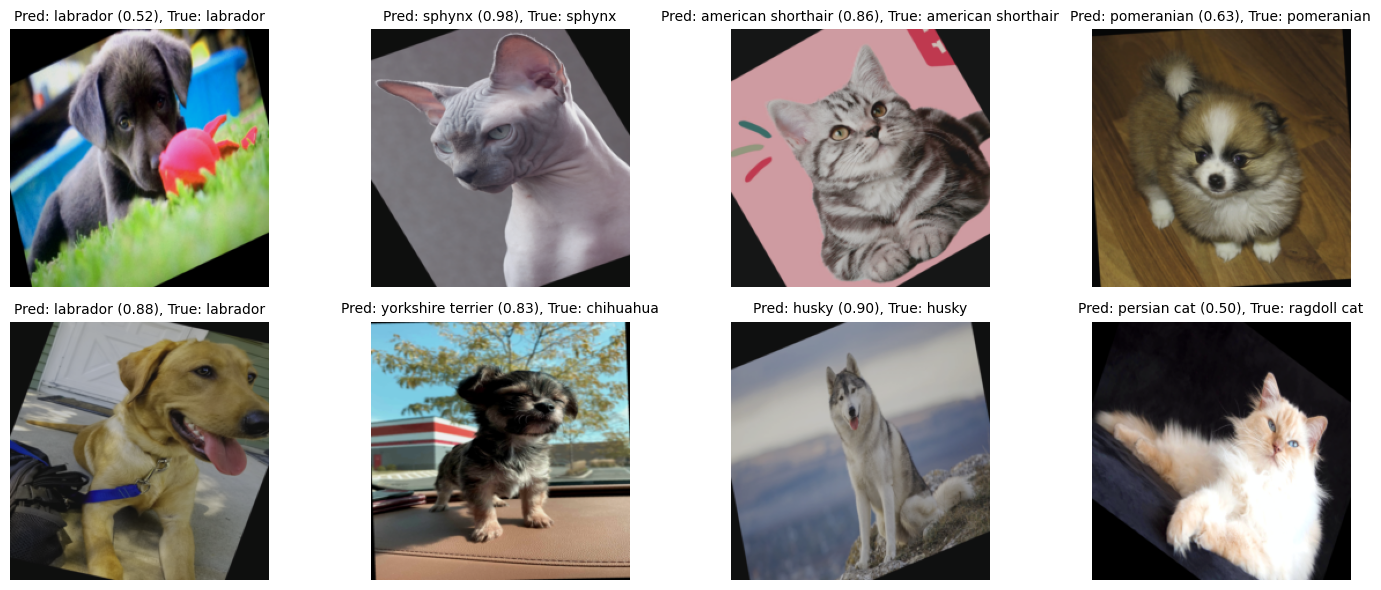

In [14]:
visualize_predictions(improved_model, val_loader, full_dataset.classes, num_images=8)  # num_images=8 для 8 фото

In [15]:
# Сохранить состояние модели в файл 'improved_model.pth'
torch.save(improved_model.state_dict(), 'improved_model_state.pth')
torch.save(improved_model, 'improved_model_full.pth')

In [16]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.3 MB/s eta 0:00:00


In [17]:
from torcheval.metrics import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score

def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    # Инициализация метрик
    accuracy = MulticlassAccuracy(num_classes=23) # 23 класса
    precision = MulticlassPrecision(num_classes=23, average='macro')
    recall = MulticlassRecall(num_classes=23, average='macro')
    f1 = MulticlassF1Score(num_classes=23, average='macro')

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # Обновление метрик
            accuracy.update(preds, labels)
            precision.update(preds, labels)
            recall.update(preds, labels)
            f1.update(preds, labels)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    # Вычисление и вывод результатов
    print(f"Test Loss: {epoch_loss:.4f}")
    print(f"Test Accuracy: {epoch_acc:.2%}")
    print(f"Precision: {precision.compute():.2%}")
    print(f"Recall: {recall.compute():.2%}")
    print(f"F1 Score: {f1.compute():.2%}")

# Пример использования:
evaluate_model(improved_model, test_loader, criterion)

Test Loss: 0.4940
Test Accuracy: 86.28%
Precision: 85.96%
Recall: 85.96%
F1 Score: 85.54%


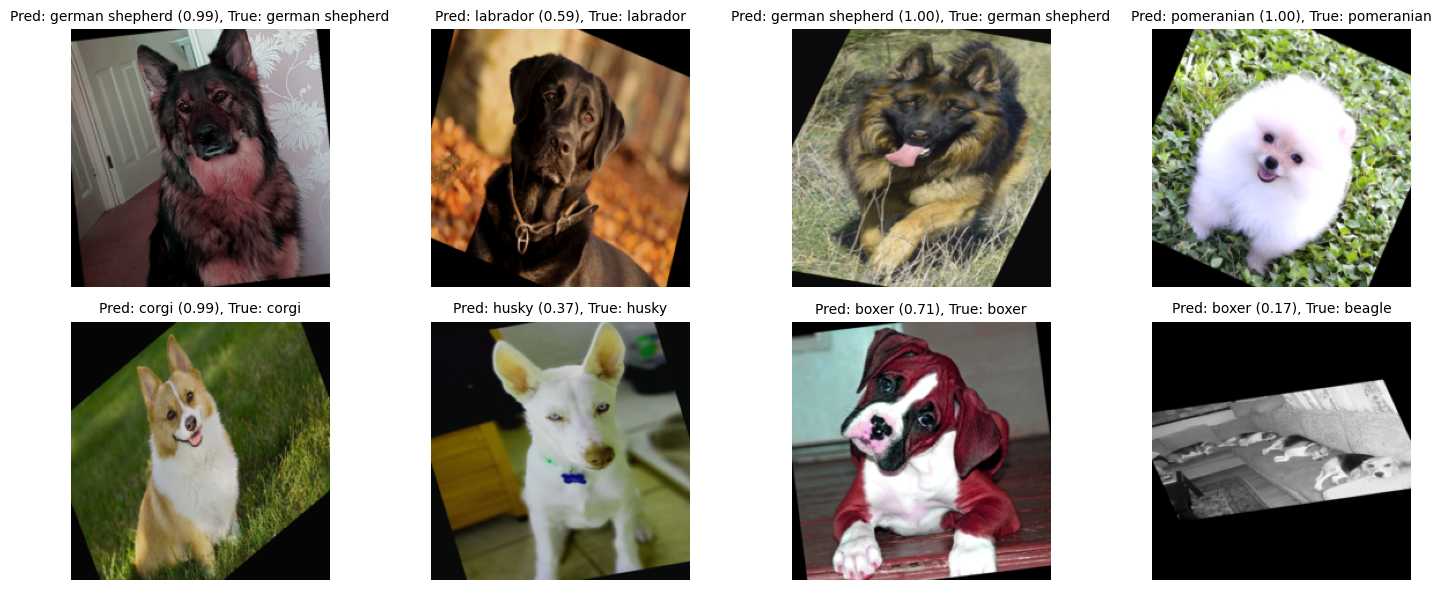

In [18]:
visualize_predictions(improved_model, test_loader, full_dataset.classes, num_images=8)